In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from classifier import *
from ntk import *
from Q_minimization import *

### Define Dataset

In [3]:
x = np.array([[1, -0.8, -0.5], [1, -0.4, -0.5], [1, 0.15, 0.3]])
y = np.array([[1.0, -1.0, 1.0]]).reshape(-1,)

### Define Dimensions

In [4]:
m = 20
d = 3

### Solve L1

In [5]:
w_0 = np.random.normal(loc=0, scale=1, size=(m, d))
a_0 = np.random.normal(loc=0, scale=1, size=(m,))

In [6]:
w_opt_L1, a_opt_L1 = solver(x, y, w_0, a_0, m, d, obj='L1')
w_opt_L1, a_opt_L1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3.9134187783484053
            Iterations: 219
            Function evaluations: 18342
            Gradient evaluations: 219


(array([[ 1.73592761e-01, -3.97701849e-01,  6.65161708e-01],
        [ 1.97133290e-01, -4.50257616e-01,  7.53696903e-01],
        [ 1.20459183e-02,  2.59444827e-02, -5.30800344e-02],
        [ 4.48733331e-02,  1.05699662e-01, -2.02405706e-01],
        [ 2.25455940e-03, -3.09841900e-03,  6.83928631e-03],
        [ 1.26324368e-01, -2.88530956e-01,  4.83275791e-01],
        [-1.49632129e-02, -4.64488444e-02,  7.23170763e-03],
        [ 1.76125479e-02, -4.92016942e-02,  7.44894506e-02],
        [ 6.57101773e-03, -1.53757478e-02,  1.85644652e-02],
        [ 5.04515455e-02,  1.24112654e-01, -2.30221292e-01],
        [ 2.49276139e-03,  5.26566593e-04, -4.38801470e-03],
        [-3.79942482e-03,  1.80777027e-03,  2.13588121e-03],
        [ 4.73703829e-03,  1.38244583e-02, -2.26368368e-02],
        [ 5.94826828e-03, -9.21293911e-03,  1.12322198e-02],
        [ 2.15738213e-01,  5.10513789e-01, -9.74386118e-01],
        [ 1.78897892e-01,  4.23259723e-01, -8.07954661e-01],
        [ 1.75279142e-01

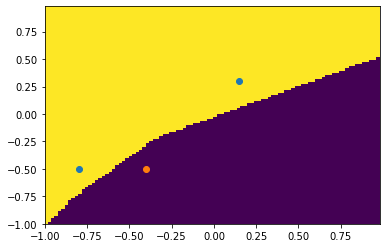

In [7]:
plot_classifier(w_opt_L1, a_opt_L1, x, y)

In [8]:
w_tilde_norms_opt_L1 = calc_w_tilde_norms(w_opt_L1, a_opt_L1)

In [9]:
minimal_margin(w_opt_L1, a_opt_L1, x, y)

1.0000005287782734

##### Check condtions are met

In [10]:
margin_constraint(flatten(w_0, a_0), x, y, m, d)

array([ 0.63504107, -2.82781568,  2.68641552])

In [11]:
margin_constraint(flatten(w_opt_L1, a_opt_L1), x, y, m, d)

array([1.87263849e-06, 5.28778273e-07, 1.85719402e-06])

### Create Symmetric Initialization

In [12]:
alpha=100

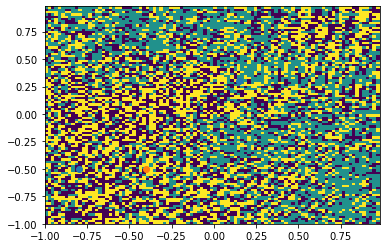

In [13]:
w_0, a_0 = symmetric_init(alpha=alpha, m=20, d=3)
plot_classifier(w_0, a_0, x, y)

### Find NTK solution

In [14]:
step_size = 0.01
epoch = 0
n_epochs = 1000

In [15]:
w_opt_ntk, a_opt_ntk = np.array(w_0), np.array(a_0)

for epoch in range(n_epochs):
    w_opt_ntk, a_opt_ntk, gamma_tilde, gamma = update_ntk(w_opt_ntk, a_opt_ntk, w_0, a_0, x, y, epoch, step_size)  

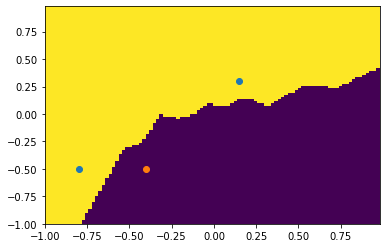

In [16]:
plot_classifier_ntk(w_opt_ntk, a_opt_ntk, w_0, a_0, x, y)

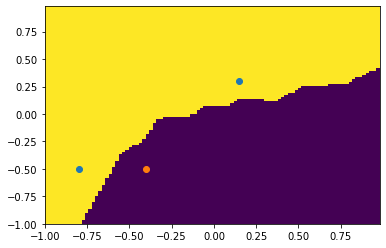

In [17]:
plot_classifier(w_opt_ntk, a_opt_ntk, x, y)

In [18]:
w_tilde_norms_ntk = calc_w_tilde_norms(w_opt_ntk, a_opt_ntk)
gamma_ntk = minimal_margin(w_opt_ntk, a_opt_ntk, x, y)

### Train Full Model

In [19]:
def solve_Q(mu, x, y, w_0, a_0, m, d):
    w_opt_Q, a_opt_Q = Q_solver(mu , x, y, w_0, a_0, m, d, obj='Q')
    _, _, _, gamma = update(w_opt_Q, a_opt_Q.reshape(1, -1), x, y, epoch)
    
    w_tilde_norms = calc_w_tilde_norms(w_opt_Q, a_opt_Q) / gamma
    excess_l1 = np.linalg.norm(w_tilde_norms, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
    #excess_l1 = np.linalg.norm(flatten(w_opt_Q, a_opt_Q), ord=2) / np.linalg.norm(flatten(w_opt_L1, a_opt_L1), ord=2) / gamma**0.5 - 1
    return excess_l1

In [20]:
step_size = 0.1
epoch = 0
n_epochs = 10000

In [21]:
training_accuracy = []
excess_l1_curve = []
consine_sim_ntk = []

training_accuracy_Q = []
excess_l1_Q_curve = []

w, a = np.array(w_0), np.array(a_0)

for epoch in range(n_epochs):
    w, a, gamma_tilde, gamma = update(w, a, x, y, epoch, step_size)
    
    w_tilde_norms = calc_w_tilde_norms(w, a) / gamma
    excess_l1 = np.linalg.norm(w_tilde_norms, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
    training_accuracy.append(gamma_tilde)
    excess_l1_curve.append(excess_l1)
    
    consine_sim_ntk.append(cosine_sim(w_tilde_norms, w_tilde_norms_ntk))
    
    estimate_Q = False
    if (epoch + 1) % 1000 == 0:
        estimate_Q = True
    if (epoch < 100) and (gamma > 0) and ((epoch + 1) % 10 == 0):
        estimate_Q = True
    if estimate_Q:      
        mu = [alpha**2/gamma_tilde] * m
        w_opt_Q, a_opt_Q = solver(x, y, w_0, a_0, m, d, obj='Q', mu=mu)
        _, _, _, gamma = update(w_opt_Q, a_opt_Q.reshape(1, -1), x, y, epoch, 0)
        w_tilde_norms_Q = calc_w_tilde_norms(w_opt_Q, a_opt_Q) / gamma
        
        excess_l1_Q = np.linalg.norm(w_tilde_norms_Q, ord=1) / np.linalg.norm(w_tilde_norms_opt_L1, ord=1) - 1
        excess_l1_Q_curve.append(excess_l1_Q)
        training_accuracy_Q.append(gamma_tilde)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -207.02758968940233
            Iterations: 8
            Function evaluations: 657
            Gradient evaluations: 8
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -58.67838673225875
            Iterations: 11
            Function evaluations: 904
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -381.63331880239764
            Iterations: 7
            Function evaluations: 576
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -81.7016831949015
            Iterations: 11
            Function evaluations: 903
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -34.829109236324506
            Iterations: 12
            Funct

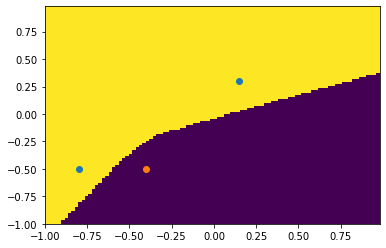

In [22]:
plot_classifier(w, a, x, y)

In [23]:
gamma_tilde

1015534.1610039269

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  
/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if sys.path[0] == '':


Text(0.5, 0, 'Training Accuracy')

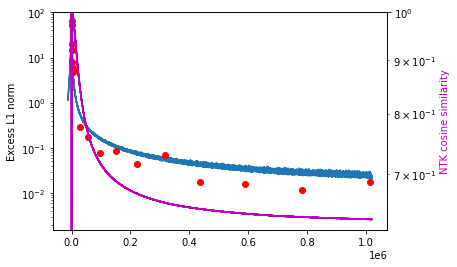

In [24]:
fig, ax1 = plt.subplots()
ax1.set_ylabel('Excess L1 norm', color='k')
ax1.plot(training_accuracy, excess_l1_curve)
ax1.plot(training_accuracy_Q, excess_l1_Q_curve, 'ro')
ax1.set_yscale('log')
ax1.set_ylim([0, 100]);

ax2 = ax1.twinx()
ax2.set_ylabel('NTK cosine similarity', color='m')
ax2.plot(training_accuracy, consine_sim_ntk, 'm')
ax2.set_yscale('log')
ax2.set_ylim([0, 1]);

xlabel('Training Accuracy')

In [26]:
min_mu = min([alpha**2/t for t in training_accuracy_Q])
max_mu = max([alpha**2/t for t in training_accuracy_Q])

min_mu, max_mu

(0.011415452044927374, 6.46546882819177)

/Users/shaharazulay/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


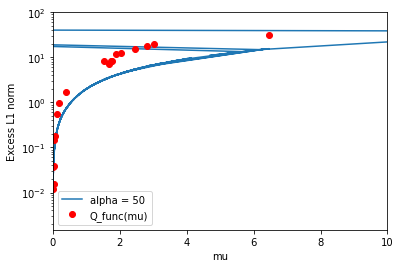

In [27]:
plot([alpha**2/t for t in training_accuracy], excess_l1_curve)
plot([alpha**2/t for t in training_accuracy_Q], excess_l1_Q_curve, 'ro')

ylabel('Excess L1 norm')
yscale('log')
ylim([0, 100])
xlim([0, 10])
xlabel('mu')
legend(['alpha = 50', 'Q_func(mu)'])

### Explore mu --> inf

In [28]:
step_size = 0.01
epoch = 0
n_epochs = 1000

In [45]:
def solve_ntk(w_0, a_0):
    w_opt_ntk, a_opt_ntk = np.array(w_0), np.array(a_0)
    while True:
        w_opt_ntk, a_opt_ntk, gamma_tilde, gamma = update_ntk(w_opt_ntk, a_opt_ntk, w_0, a_0, x, y, epoch, step_size)
        if gamma >= 1:
            break
    return w_opt_ntk, a_opt_ntk

In [27]:
mu_val = 100
w_0, a_0 = symmetric_init(alpha=10, m=20, d=3)
w_opt_Q, a_opt_Q = solver(x, y, w_0, a_0, m, d, obj='Q', mu=[mu_val] * m, optim_tol=1e-5)
w_tilde_norms_Q = calc_w_tilde_norms(w_opt_Q, a_opt_Q)

np.linalg.norm(w_tilde_norms_Q, ord=1), mu_val*m

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -999.9999996886417
            Iterations: 5
            Function evaluations: 411
            Gradient evaluations: 5


(2000.0001781499398, 2000)

In [28]:
np.linalg.norm(w_opt_Q, ord=2, axis=1)

array([10.        , 10.00006536, 10.        , 10.00012806,  9.99971215,
       10.00027048, 10.        , 10.        , 10.        , 10.00021104,
       10.00001106,  9.99995474, 10.        , 10.00001154, 10.00029797,
        9.99997411, 10.        , 10.        , 10.        ,  9.99979706])

In [49]:
for mu_val in [100, 1000, 1e5, 1e7, 1e9, 1e10]: 
    mu = [mu_val] * m
    w_0, a_0 = symmetric_init(alpha=mu_val**2, m=20, d=3)
    w_opt_ntk, a_opt_ntk = solve_ntk(w_0, a_0)
    
    gamma_ntk = minimal_margin(w_opt_ntk, a_opt_ntk, x, y)
    w_tilde_norms_ntk = calc_w_tilde_norms(w_opt_ntk, a_opt_ntk) / gamma_ntk    
    
    w_0, a_0 = symmetric_init(alpha=1, m=20, d=3)
    w_opt_Q, a_opt_Q = solver(x, y, w_0, a_0, m, d, obj='Q', mu=mu, optim_tol=1e-5)
    gamma_Q = minimal_margin(w_opt_Q, a_opt_Q, x, y)
    w_tilde_norms_Q = calc_w_tilde_norms(w_opt_Q, a_opt_Q) / gamma_Q
    
    excess_L1 = np.linalg.norm(w_tilde_norms_Q, ord=1) / np.linalg.norm(w_tilde_norms_ntk, ord=1) - 1
    print(excess_L1)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -999.9999999978915
            Iterations: 7
            Function evaluations: 576
            Gradient evaluations: 7
-0.8939464670504736
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -9999.999999953054
            Iterations: 8
            Function evaluations: 659
            Gradient evaluations: 8
3.911635866741201
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -999999.9999603773
            Iterations: 12
            Function evaluations: 996
            Gradient evaluations: 12
193.7510258704467
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -99999999.60128812
            Iterations: 41
            Function evaluations: 3534
            Gradient evaluations: 41
-0.8757237908531892
Optimization terminated successfully.    (Exit mode 0)
            Current func

In [50]:
np.linalg.norm(w_opt_ntk, axis=1), gamma_ntk

(array([1.00000000e+20, 1.00029860e+20, 1.00000000e+20, 1.00000000e+20,
        1.00115231e+20, 9.98297460e+19, 9.99475624e+19, 1.00000000e+20,
        9.99251252e+19, 1.00000000e+20, 1.00000000e+20, 9.99702428e+19,
        1.00000000e+20, 1.00000000e+20, 9.98848919e+19, 1.00170283e+20,
        1.00052729e+20, 1.00000000e+20, 1.00074930e+20, 1.00000000e+20]),
 -1.1946545285153552e+38)

In [52]:
np.linalg.norm(w_opt_Q, axis=1), gamma_Q

(array([ 99835.12925518, 101146.56738456, 100016.56617198, 100553.60121808,
        100464.25190579,  99736.82161901,  99959.12898192, 100710.41638985,
        101017.8076026 ,  99407.41027792,  99744.48390166, 100197.48135476,
         99491.05465203,  99935.43604688, 100104.32045679, 100221.6122438 ,
        100596.16812743,  99188.67847869,  99795.99570881,  99992.35724325]),
 584607394.4297371)

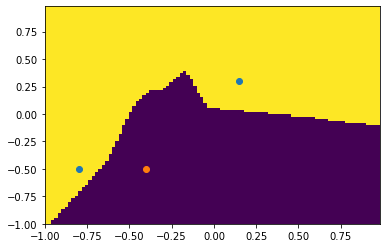

In [53]:
plot_classifier(w_opt_Q, a_opt_Q, x, y)

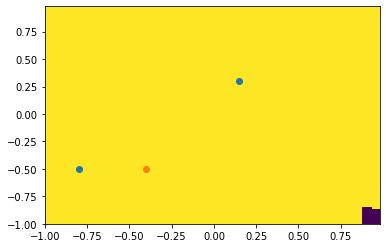

In [54]:
plot_classifier(w_opt_ntk, a_opt_ntk, x, y)

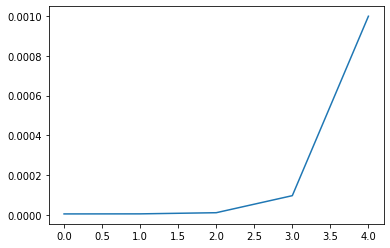

In [60]:
plot([v/(mu_val*m) for v, mu_val in zip(r, mu)])

In [11]:
r = []
for mu_val in [0.01, 0.1, 0.5, 0.75, 1, 1.25, 2, 5, 10]: 
    mu = [mu_val] * m
    w_0, a_0 = symmetric_init(alpha=1, m=20, d=3)
   
    w_opt_Q, a_opt_Q = solver(x, y, w_0, a_0, m, d, obj='Q', mu=mu, optim_tol=1e-5)
    gamma_Q = minimal_margin(w_opt_Q, a_opt_Q, x, y)
    print(gamma_Q)
    w_tilde_norms_Q = calc_w_tilde_norms(w_opt_Q, a_opt_Q)
    r.append(np.linalg.norm(w_tilde_norms_Q, ord=1))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 10.751599931120392
            Iterations: 287
            Function evaluations: 24148
            Gradient evaluations: 286
0.9999950726983836
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 2.7888806486005255
            Iterations: 123
            Function evaluations: 10462
            Gradient evaluations: 123
0.9999914888157558
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4.872739220058211
            Iterations: 91
            Function evaluations: 7758
            Gradient evaluations: 91
0.9999954670769956
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -7.497487544495298
            Iterations: 82
            Function evaluations: 6781
            Gradient evaluations: 82
0.999994017470901
Optimization terminated successfully.    (Exit mode 0)
            

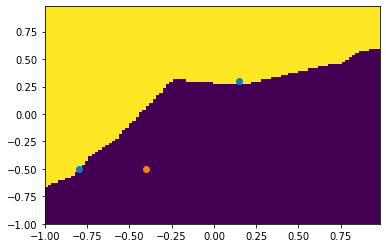

In [30]:
plot_classifier(w_opt_Q, a_opt_Q, x, y)

In [73]:
mu = [0.01, 0.1, 0.5, 0.75, 1, 1.25, 2, 5, 10]

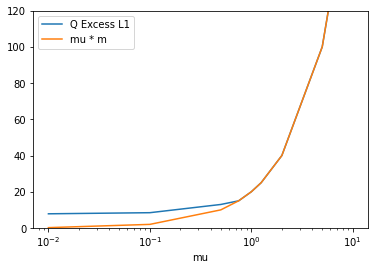

In [84]:
plot(mu, [v for v, mu_val in zip(r, mu)])
plot(mu, [(mu_val*m) for v, mu_val in zip(r, mu)])
xlabel('mu')
ylim([0, 120])
xscale('log')
legend(['Q Excess L1', 'mu * m'])

In [10]:
for alpha in [1, 10, 100, 1000]:
    w_0, a_0 = symmetric_init(alpha=alpha, m=20, d=3)
    w_opt_L2, a_opt_L2 = solver(x, y, w_0, a_0, m, d, obj='L2')
    w_tilde_norms_L2 = calc_w_tilde_norms(w_opt_L2, a_opt_L2)
    print(np.linalg.norm(w_tilde_norms_L2, ord=1))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7.470214883979356
            Iterations: 1876
            Function evaluations: 154885
            Gradient evaluations: 1876
8.302226069583892
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 90.90221733932464
            Iterations: 505
            Function evaluations: 43505
            Gradient evaluations: 504
7.932690645233391
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 733.7631295200604
            Iterations: 400
            Function evaluations: 34116
            Gradient evaluations: 399
8.301945050288463
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7337.729508773504
            Iterations: 629
            Function evaluations: 54188
            Gradient evaluations: 627
8.300212499806317
